# MA Model

See write up for AR model.  I this case, however, the prediction is based on a series of shocks, i.e., the noise $\epsilon$ in the timeseries:

$$
y_t = \sum_{n=0}^{t-1} \beta_n \epsilon_n.
$$

How then, do we estimate the noise?  In this example, I try a rolling average

Text(0, 0.5, 'flux')

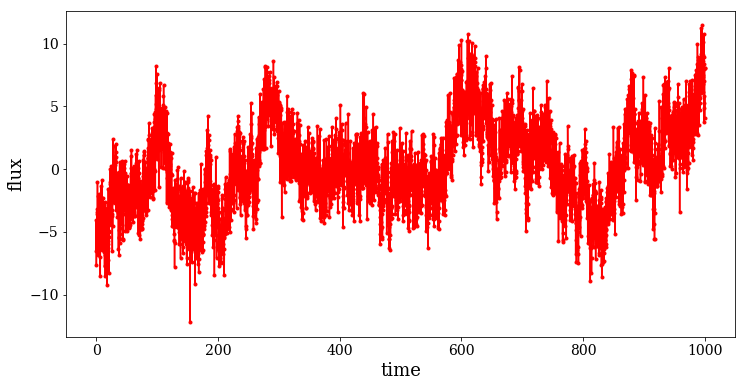

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 12,6
sp.random.seed(111111)

t = sp.r_[0:1000:5000j]
f = gen_lc(t,30)*3
s = 0.0*sp.sin(2*sp.pi*t/55)
n = sp.randn(len(f))*1.5
f = f + s + n

F,(ax1) = plt.subplots(1,1)
ax1.plot(t,f,'r.-')
ax1.set_xlabel('time')
ax1.set_ylabel('flux')

Let's give it a memory of 20 time steps, and remove the running mean on this time scale.  The game is to iteritively estimate the running mean, remove, and refit the reaning noise.

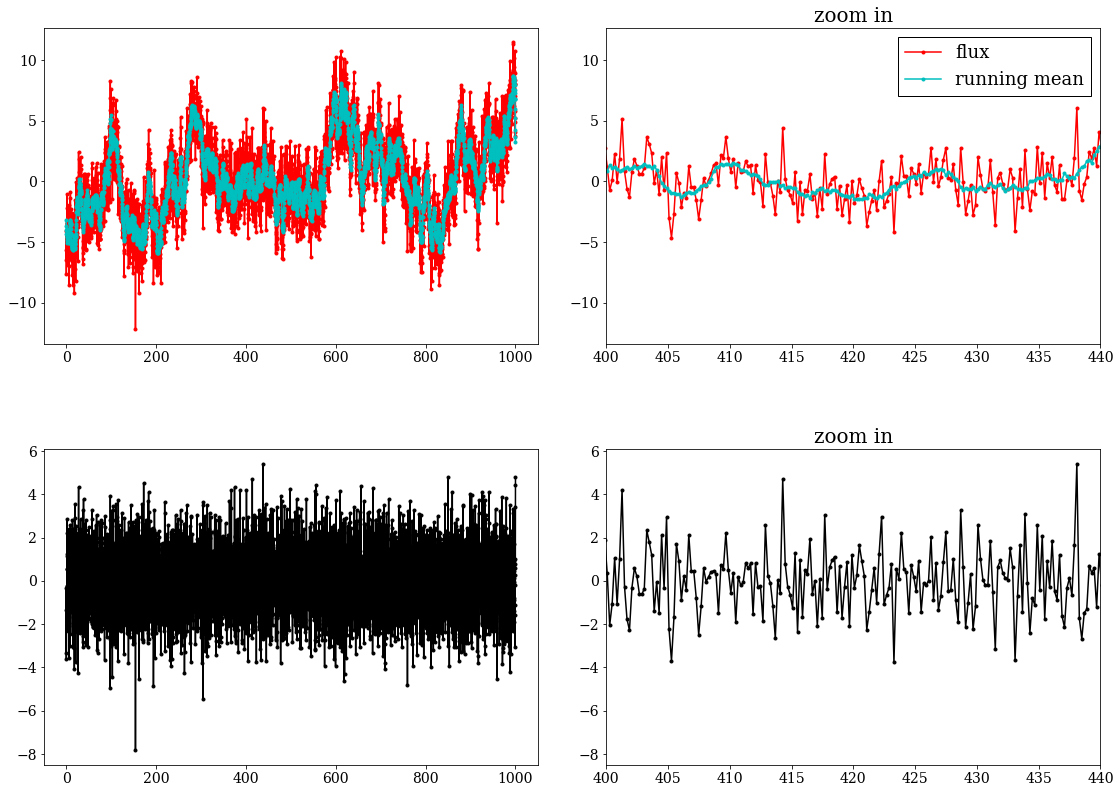

In [2]:
N_memory = 11

window = sp.ones(N_memory)
window /= sp.sum(window)

running_mean = sp.convolve(f,window,'same')

F,( (ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
ax1.plot(t,f,'r.-',label='flux')
ax1.plot(t, running_mean,'c.-',label='running mean')

ax2.plot(t,f,'r.-',label='flux')
ax2.plot(t, running_mean,'c.-',label='running mean')
ax2.set_xlim([400,440])
ax2.set_title('zoom in')

residual = f - running_mean
ax3.plot(t,residual,'k.-')
ax4.plot(t,residual,'k.-')
ax4.set_xlim([400,440])
ax4.set_title('zoom in')


ax2.legend()

F.tight_layout()
F.set_size_inches(16,12)


5.576241743825744 -7.836246325956687 0.0019058411379546112 1.2173010166258513 5000
7.531251268850625 -8.339413970402212 0.008200463435705177 1.4593471702051957 5000


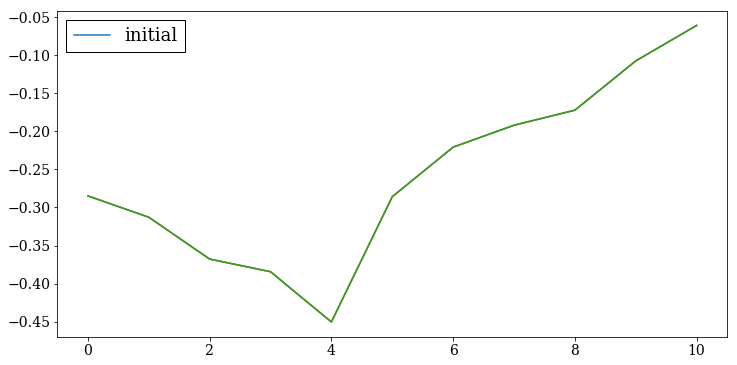

In [3]:
from scipy import linalg

def get_coeffs(noise,N_memory):
    noise_roll = []
    for m in range(N_memory):
        noise_tmp = sp.roll(noise,-(m+1))
        noise_tmp[-(m+1):] = 0
        noise_roll.append(noise_tmp)

    noise_roll= sp.array(noise_roll)

    #fill in the design matrices
    C = []
    for ii in range(len(noise_roll)):
        C.append(sp.sum(noise*noise_roll[ii]))
    C = sp.array(C)

    A = []
    for ii in range(len(noise_roll)):
        row = []
        for jj in range(len(noise_roll)):
            row.append(sp.sum(noise_roll[ii]*noise_roll[jj]))
        A.append(row)
    A = sp.array(A)

    #print('A shape, C shape',A.shape, C.shape)
    
    B = linalg.solve(A,C)
    return B

#must mask the residuals in this way, because the running mean is not reliable at the start/end
B = get_coeffs(residual[N_memory//2:-N_memory//2], N_memory)
F,(ax1) = plt.subplots(1,1)
ax1.plot(B,label='initial')
#now, iterate
N_iter = 2

for ii in range(N_iter):
    #don't want bad predictions to ruing the noise estimates at these parts.
    pred = sp.convolve(residual,B,'valid') + running_mean[N_memory - 1:]
    pred = sp.r_[running_mean[0:N_memory-1], pred]
    
    running_mean = sp.convolve(pred,window,'same')
    residual = f - running_mean
    print(max(residual),min(residual),sp.mean(residual),sp.mean(abs(residual)),len(residual))
    Bdumb = get_coeffs(residual[N_memory//2:-N_memory//2],N_memory)
    ax1.plot(B)
    
ax1.legend();

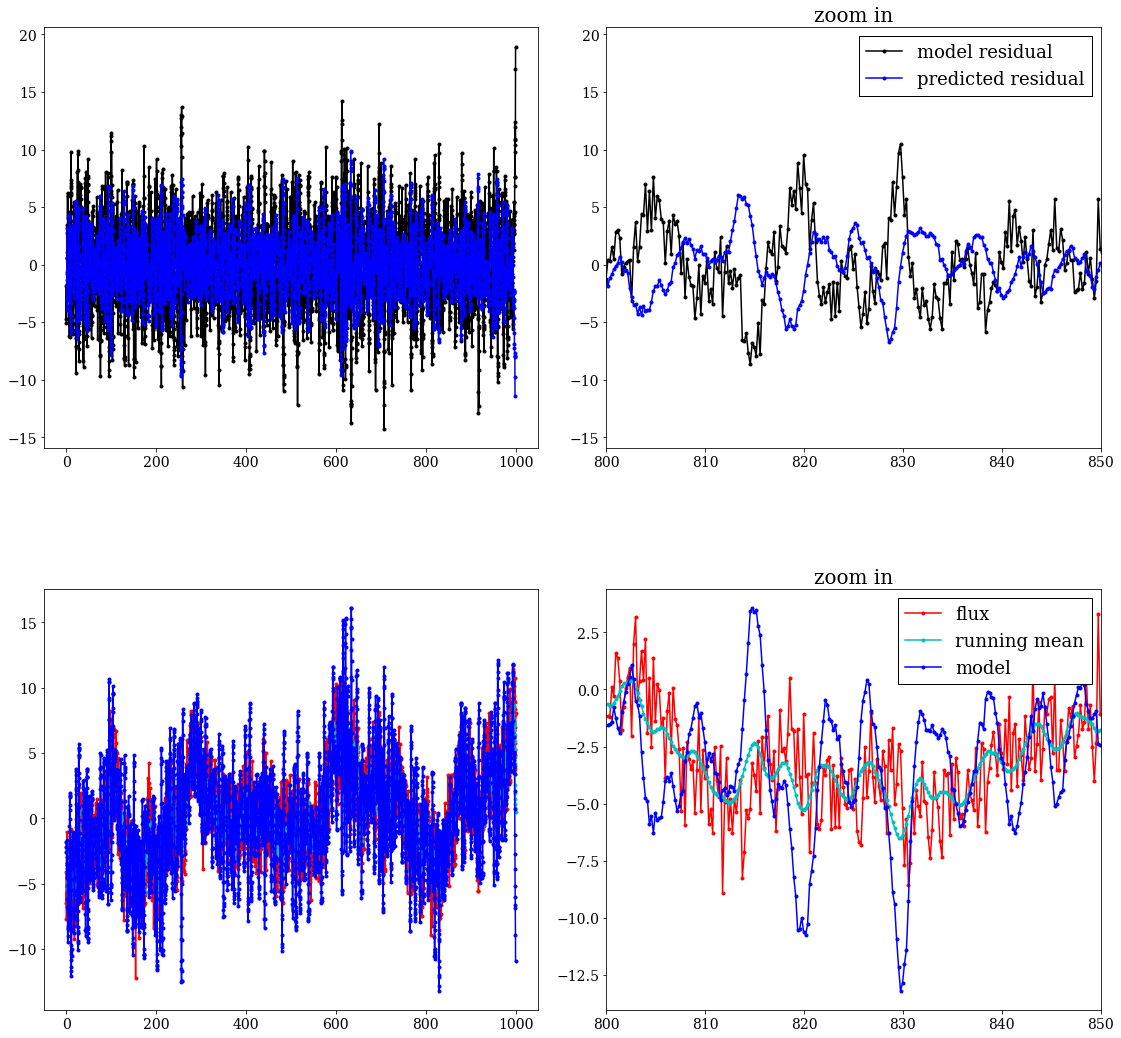

In [4]:
#now do it one more time, to get the final prediction and residual
pred_residual = sp.convolve(residual,B,'valid')
pred =  sp.convolve(residual,B,'valid') + running_mean[N_memory - 1:]
pred = sp.r_[running_mean[0:N_memory - 1], pred]
residual = f - pred

F,( (ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
plot_xlim = [800,850]

ax1.plot(t,residual,'k.-',label='model residual')
ax1.plot(t[N_memory//2 - 1:-N_memory//2],pred_residual,'b.-',label='predicted residual')

ax2.plot(t,residual,'k.-',label='model residual')
ax2.plot(t[N_memory//2 - 1:-N_memory//2],pred_residual,'b.-',label='predicted residual')
ax2.set_xlim(plot_xlim)
ax2.legend()
ax2.set_title('zoom in')

ax3.plot(t,f,'r.-',label='flux')
ax3.plot(t, running_mean,'c.-',label='running mean')
ax3.plot(t, pred,'b.-',label='model')


m = (t > plot_xlim[0]) & (t < plot_xlim[1])
ax4.plot(t[m],f[m],'r.-',label='flux')
ax4.plot(t[m], running_mean[m],'c.-',label='running mean')
ax4.plot(t[m], pred[m],'b.-',label='model')

ax4.set_xlim(plot_xlim)
#ax4.set_ylim([2.5,7.5])
ax4.set_title('zoom in')

ax4.legend()



F.tight_layout()
F.set_size_inches(16,16)